se cargan e instalan las librerias necesarias

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import datetime
import re
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

se cargan los datos obtenidos mediante webscraping

In [4]:
File = pd.ExcelFile('DatosWoS.xlsx')
df=File.parse('Sheet1')


In [5]:
def convertfecha(month_name):
    datetime_object = datetime.datetime.strptime(month_name, "%b")
    month_number = datetime_object.month
    return month_number

se crea un dataframe con la fecha y el numero de publicaciones mensuales

In [6]:
df_year = df.sort_values('Año')
df_reorder = df_year.groupby(["Año","Mes"]).count()
df_back = df_reorder.reset_index()
df_fdf = pd.DataFrame(df_back.Titulo).copy()
df_fdf["fecha"] = df_back.Año.apply(str)  + " " + df_back.Mes.apply(str) 
df_fdf.reindex(columns = ["fecha","Titulo"])
df_fdf.rename({"Titulo" :"Publicaciones"},axis = 1)


,Publicaciones,fecha
0,4,2010 -
1,1,2010 Aug
2,2,2010 Feb
3,1,2010 Jan
4,1,2010 Jan-apr
...,...,...
82,1,2021 May
83,1,2021 May-aug
84,2,2021 Oct
85,1,2021 Sep-oct


In [7]:
list_df = df_fdf.values.tolist()

list_df_new = []
for i in range(len(list_df)):
    if any(ch.isdigit() for ch in list_df[i][1]) == True:
        list_df_new.append(list_df[i])


In [8]:
for i in range(len(list_df_new)):
    if ("-" in list_df_new[i][1]) == True:
        month = list_df_new[i][1].split()[1]
        
        year = list_df_new[i][1].split()[0]
        year = year.replace(" ","")
        month = month.split("-")[0]
        new_value = year + " " + month
        for j in range(len(list_df_new)):
            if list_df_new[j][1] == new_value:
                list_df_new[j][0] += 1
    if ("." in list_df_new[i][1]) == True:
        month = list_df_new[i][1].split()[1]
        
        year = list_df_new[i][1].split()[0]
        year = year.replace(" ","")
        month = month.split(".")[0]
        new_value = year + " " + month
        for j in range(len(list_df_new)):
            if list_df_new[j][1] == new_value:
                list_df_new[j][0] += 1    
flist_df = []
for i in range(len(list_df_new)):
    if ("-" in list_df_new[i][1]) == False and ("2021" in list_df_new[i][1]) == False and ("." in list_df_new[i][1]) == False and ("Fal" in list_df_new[i][1]) == False and ("Sum" in list_df_new[i][1]) == False and ("Win" in list_df_new[i][1]) == False and  ("Spr" in list_df_new[i][1]) == False:
        flist_df.append(list_df_new[i])


In [9]:
print(flist_df[5])
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cmonths = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

for i in range(len(flist_df)):
    month = flist_df[i][1].split()[1]
    month = month.replace(".","")
    month = re.sub("[!,*)@#%(&$_?.^:-]'", '', month)
    for j in range(9):
        month = month.replace(str(j),"")
    for k in range(len(months)):
        month = month.replace(months[k],cmonths[k])
        month = month.replace(months[k].lower(),cmonths[k])
    if len(month) > 3:
        month = month[:3]
    year = flist_df[i][1].split()[0]
    year = year.replace(" ","")
    month = convertfecha(month)
    new_value = str(year) + "-" + str(month)


[1, '2010 Mar']


se crea un csv conteniendo los datos ordenados

In [10]:
nfdf = pd.DataFrame(flist_df,columns=["Publicaciones","Fecha"])

In [11]:
nfdf.to_csv('publications.csv',index=False)

se prepara el dataset con los datos del csv, luego se preparan para la red LSTM

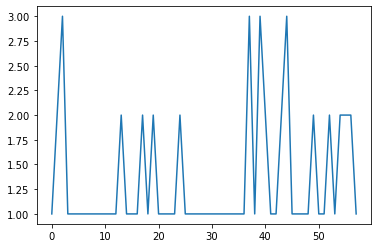

In [12]:
dataset = pandas.read_csv('publications.csv', usecols=[0], engine='python')
plt.plot(dataset)
plt.show()

In [13]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [14]:
# load the dataset
dataframe = pandas.read_csv('publications.csv', usecols=[0], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [15]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [16]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

38 20


In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

se crea y ajusta la red LSTM

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
36/36 - 1s - loss: 0.0609 - 877ms/epoch - 24ms/step
Epoch 2/100
36/36 - 0s - loss: 0.0580 - 34ms/epoch - 945us/step
Epoch 3/100
36/36 - 0s - loss: 0.0564 - 31ms/epoch - 861us/step
Epoch 4/100
36/36 - 0s - loss: 0.0551 - 31ms/epoch - 861us/step
Epoch 5/100
36/36 - 0s - loss: 0.0542 - 30ms/epoch - 834us/step
Epoch 6/100
36/36 - 0s - loss: 0.0540 - 29ms/epoch - 806us/step
Epoch 7/100
36/36 - 0s - loss: 0.0536 - 28ms/epoch - 778us/step
Epoch 8/100
36/36 - 0s - loss: 0.0533 - 29ms/epoch - 806us/step
Epoch 9/100
36/36 - 0s - loss: 0.0532 - 29ms/epoch - 806us/step
Epoch 10/100
36/36 - 0s - loss: 0.0532 - 28ms/epoch - 778us/step
Epoch 11/100
36/36 - 0s - loss: 0.0534 - 31ms/epoch - 861us/step
Epoch 12/100
36/36 - 0s - loss: 0.0532 - 30ms/epoch - 834us/step
Epoch 13/100
36/36 - 0s - loss: 0.0530 - 30ms/epoch - 834us/step
Epoch 14/100
36/36 - 0s - loss: 0.0530 - 29ms/epoch - 806us/step
Epoch 15/100
36/36 - 0s - loss: 0.0532 - 29ms/epoch - 806us/step
Epoch 16/100
36/36 - 0s - loss: 0.

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 11ms/step
Train Score: 0.46 RMSE
Test Score: 0.78 RMSE


se entrena y testea la red 

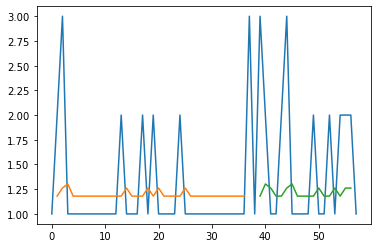

In [22]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

se prueba la red con datos en regresion

Epoch 1/100
36/36 - 1s - loss: 0.0609 - 880ms/epoch - 24ms/step
Epoch 2/100
36/36 - 0s - loss: 0.0576 - 28ms/epoch - 778us/step
Epoch 3/100
36/36 - 0s - loss: 0.0556 - 29ms/epoch - 806us/step
Epoch 4/100
36/36 - 0s - loss: 0.0544 - 29ms/epoch - 806us/step
Epoch 5/100
36/36 - 0s - loss: 0.0535 - 27ms/epoch - 750us/step
Epoch 6/100
36/36 - 0s - loss: 0.0532 - 29ms/epoch - 806us/step
Epoch 7/100
36/36 - 0s - loss: 0.0530 - 29ms/epoch - 806us/step
Epoch 8/100
36/36 - 0s - loss: 0.0528 - 28ms/epoch - 778us/step
Epoch 9/100
36/36 - 0s - loss: 0.0529 - 28ms/epoch - 778us/step
Epoch 10/100
36/36 - 0s - loss: 0.0528 - 28ms/epoch - 778us/step
Epoch 11/100
36/36 - 0s - loss: 0.0526 - 28ms/epoch - 778us/step
Epoch 12/100
36/36 - 0s - loss: 0.0527 - 27ms/epoch - 750us/step
Epoch 13/100
36/36 - 0s - loss: 0.0527 - 27ms/epoch - 750us/step
Epoch 14/100
36/36 - 0s - loss: 0.0526 - 27ms/epoch - 750us/step
Epoch 15/100
36/36 - 0s - loss: 0.0527 - 28ms/epoch - 778us/step
Epoch 16/100
36/36 - 0s - loss: 0.

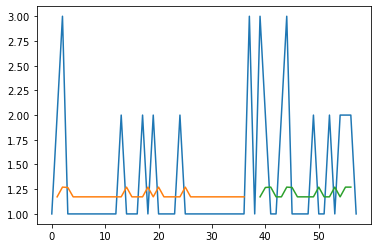

In [23]:
# LSTM para las publicaciones 2010-2021 con regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('publications.csv', usecols=[0], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

se realiza una red LSTM con window regression framing

Epoch 1/100
34/34 - 1s - loss: 0.0286 - 869ms/epoch - 26ms/step
Epoch 2/100
34/34 - 0s - loss: 0.0268 - 27ms/epoch - 794us/step
Epoch 3/100
34/34 - 0s - loss: 0.0265 - 29ms/epoch - 853us/step
Epoch 4/100
34/34 - 0s - loss: 0.0257 - 28ms/epoch - 824us/step
Epoch 5/100
34/34 - 0s - loss: 0.0254 - 27ms/epoch - 794us/step
Epoch 6/100
34/34 - 0s - loss: 0.0252 - 27ms/epoch - 794us/step
Epoch 7/100
34/34 - 0s - loss: 0.0250 - 28ms/epoch - 824us/step
Epoch 8/100
34/34 - 0s - loss: 0.0250 - 29ms/epoch - 853us/step
Epoch 9/100
34/34 - 0s - loss: 0.0249 - 26ms/epoch - 765us/step
Epoch 10/100
34/34 - 0s - loss: 0.0250 - 27ms/epoch - 794us/step
Epoch 11/100
34/34 - 0s - loss: 0.0250 - 28ms/epoch - 824us/step
Epoch 12/100
34/34 - 0s - loss: 0.0249 - 27ms/epoch - 794us/step
Epoch 13/100
34/34 - 0s - loss: 0.0248 - 26ms/epoch - 765us/step
Epoch 14/100
34/34 - 0s - loss: 0.0249 - 26ms/epoch - 765us/step
Epoch 15/100
34/34 - 0s - loss: 0.0248 - 26ms/epoch - 765us/step
Epoch 16/100
34/34 - 0s - loss: 0.

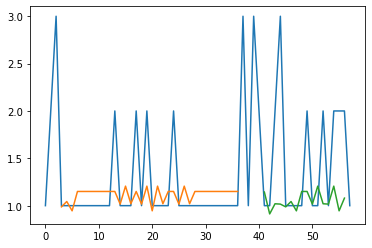

In [24]:
# LSTM para las publicaciones 2010-2021 con window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('publications.csv', usecols=[0], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()